# iCAT Correlate
---

#### Overview
This notebooks registers sets of high-mag EM tiles to the corresponding low-mag EM tile. The resulting transformation is propagated to each fluorescence stack such that it becomes correlated to the high-mag EM stack.

#### Packages

In [1]:
import re
from pathlib import Path
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import altair as alt

import renderapi
import icatapi

/home/skaracoban/miniconda3/envs/icat/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/tmp/ipykernel_3230958/1361804840.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


#### Settings

In [2]:
# pandas display settings
pd.set_option('display.max_rows', 20)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 15)

# Indirectly enable autocomplete
%config Completer.use_jedi = False

## Set up `render-ws` environment
---

In [3]:
# `render` project parameters
# ---------------------------
from scripted_render_pipeline import basic_auth
import requests

# create an authorized session
auth = basic_auth.load_auth()
sesh = requests.Session()
sesh.auth = auth

owner = 'skaracoban'
project = '20240530_SK001'
# Project directory
dir_project = Path("/long_term_storage/skaracoban/data/20240530_SK001/T1")

# Create a renderapi.connect.Render object
# ----------------------------------------
render_connect_params = {
    'host': 'http://localhost',
    'port': 8081,
    'owner': owner,
    'project': project,
    'client_scripts': '/home/catmaid/render/render-ws-java-client/src/main/scripts',
    'memGB': '2G',
    "session": sesh
}


render = renderapi.connect(**render_connect_params)
render.make_kwargs()

{'host': 'http://localhost',
 'port': 8081,
 'owner': 'skaracoban',
 'project': '20240530_SK001',
 'client_scripts': '/home/catmaid/render/render-ws-java-client/src/main/scripts',
 'client_script': '/home/catmaid/render/render-ws-java-client/src/main/scripts/run_ws_client.sh',
 'memGB': '2G'}

In [4]:
# try:
#     renderapi.pointmatch.delete_collection(f"{project}_minimontage_points", render=render)
# except renderapi.errors.RenderError as e:
#     print(e)

In [5]:
# Infer stack and section info
# ----------------------------
stacks = renderapi.render.get_stacks_by_owner_project(render=render, **render_connect_params)
stacks_EM = [stack for stack in stacks if 'EM' in stack]
stacks_FM = [stack for stack in stacks if 'EM' not in stack]
stacks_4_overlap = {
    'hiMag': 'EM_himag_world',  # raw hi-mag EM stack
    'loMag': 'EM_lomag_world',  # raw low-mag EM stack
}
stacks_2_correlate = {
    'hiMag': 'EM_himag_stitched',  # aligned hi-mag EM stack
    'loMag': 'EM_lomag_overlaid'  # overlaid low-mag EM stack
}
stack_mm = 'EM_minimontages'
match_collection = f"{project}_minimontage_points"

# Output
# ------
out = f"""\
all stacks.................... {stacks}
EM stacks..................... {stacks_EM}
FM stacks..................... {stacks_FM}
mini-montage stack............ {[stack_mm]}
stacks to determine overlap... {stacks_4_overlap}
stacks to correlate........... {stacks_2_correlate}
match collection.............. {match_collection}
...
"""
print(out)

# Create stacks DataFrame
# ------------------------
df_project = icatapi.create_stacks_DataFrame(stacks=list(stacks_2_correlate.values()),
                                             render=render, **render_connect_params).dropna(axis=1)
df_project.groupby('stack')\
          .apply(lambda x: x.sample(1))

all stacks.................... ['EM_minimontages', 'EM_lomag_world', 'EM_himag_world', 'EM_lomag_overlaid', 'exc_470nm_overlaid', 'EM_himag_montaged', 'EM_lomag', 'exc_470nm', 'EM_himag', 'EM_himag_stitched_filtered', 'EM_himag_stitched']
EM stacks..................... ['EM_minimontages', 'EM_lomag_world', 'EM_himag_world', 'EM_lomag_overlaid', 'EM_himag_montaged', 'EM_lomag', 'EM_himag', 'EM_himag_stitched_filtered', 'EM_himag_stitched']
FM stacks..................... ['exc_470nm_overlaid', 'exc_470nm']
mini-montage stack............ ['EM_minimontages']
stacks to determine overlap... {'hiMag': 'EM_himag_world', 'loMag': 'EM_lomag_world'}
stacks to correlate........... {'hiMag': 'EM_himag_stitched', 'loMag': 'EM_lomag_overlaid'}
match collection.............. 20240530_SK001_minimontage_points
...



/tmp/ipykernel_3230958/1491083611.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(1))


tileId    z   width  height   minint   maxint  \
stack                                                                       
EM_himag_sti... 313  t025_z2_y9_x1  2.0  4096.0  4096.0  31302.0  36621.0   
EM_lomag_ove... 432    t0_z0_y0_x0  0.0  4096.0  4096.0  31170.0  35660.0   

                       imagePyramid          tforms           stack sectionId  \
stack                                                                           
EM_himag_sti... 313  [0, 1, 2, 3...  [M=[[1.0000...  EM_himag_st...      S003   
EM_lomag_ove... 432  [0, 1, 2, 3...  [M=[[1.0000...  EM_lomag_ov...      S001   

                     imageRow  imageCol       stageX       stageY  
stack                                                              
EM_himag_sti... 313         9         1 -7383.700360  1399.448769  
EM_lomag_ove... 432         0         0 -7157.427625  1742.464102

## Create mini-montages
---

### Find overlapping tiles

Find the raw (unmontaged) lil EM tiles that overlap with each big EM tile.
Will store this information in a `DataFrame` resembling
```python
[1]:  df_overlapping

[1]: section  z  big EM tileId                  overlapping lil EM tileIds
     S001     1  'aaa_big_EM-S001-00001x00001'  ['aaa_lil_EM-S001-00012x00013','aab_lil_EM-S001-00013x00013',...]
     S001     1  'aab_big_EM-S001-00002x00001'  ['aaq_lil_EM-S001-00027x00012','aar_lil_EM-S001-00026x00012',...]
     S001     1  'aad_big_EM-S001-00001x00000'  ['aek_lil_EM-S001-00025x00006','ael_lil_EM-S001-00024x00006',...]
     ...
     S004     4  'aad_big_EM-S004-00003x00003'  ['aio_lil_EM-S004-00013x00000','aip_lil_EM-S004-00012x00000',...]
```

For this to be done correctly, we need to look at the tiles as they are in "real" physical space (i.e. based on their FOV and stage position (all in microns)). Since tiles are imported into `render-ws` in "pixel" space and the pixel size gets omitted from the specification, this is unfortunately complicated. Nevertheless, we can create some functionality to transform into real physical space.

  0%|          | 0/3 [00:00<?, ?it/s]

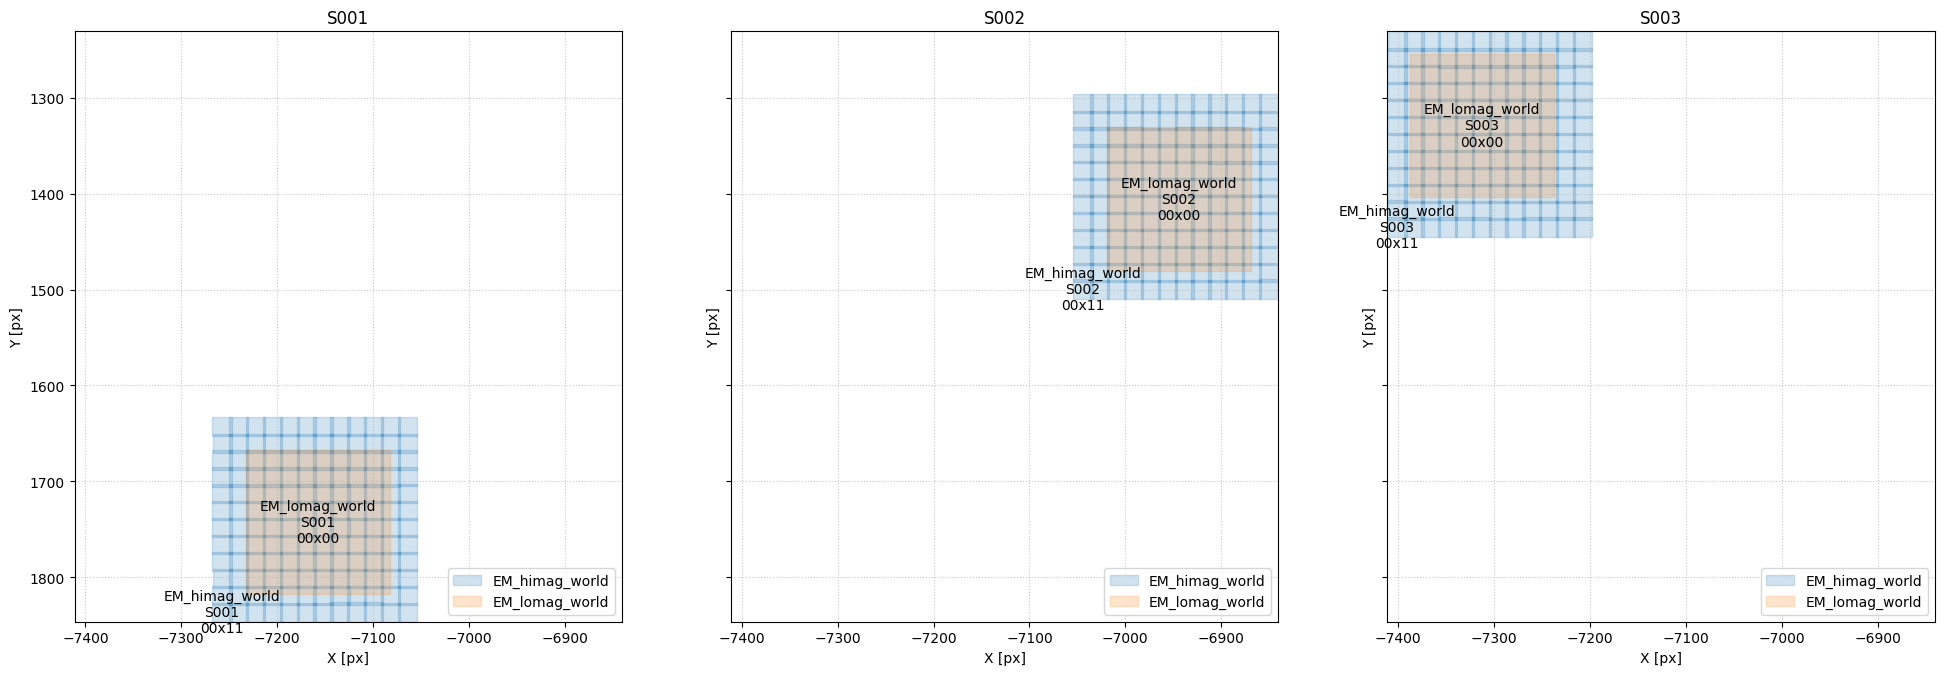

In [6]:
icatapi.plot_tile_map(stacks=list(stacks_4_overlap.values()),
                      render=render)

In [7]:
# Initialize DataFrame of overlapping tiles
df_overlapping = icatapi.create_stack_DataFrame(stack=stacks_4_overlap['loMag'],
                                                render=render, **render_connect_params)

# Create columns for overlapping tile data
df_overlapping['overlappingTileIds'] = None
df_overlapping['minx'] = np.nan
df_overlapping['miny'] = np.nan
df_overlapping['maxx'] = np.nan
df_overlapping['maxy'] = np.nan

# Loop through big EM tiles
for i, tile_loMag in tqdm(df_overlapping.iterrows(),
                          total=len(df_overlapping)):

    # Get bounding box of each big EM tile from tile specification
    bbox = renderapi.tilespec.get_tile_spec(stack=tile_loMag['stack'],
                                            tile=tile_loMag['tileId'],
                                            render=render).bbox

    # Get overlapping tiles
    overlapping_tileIds = [ts.tileId for ts in \
                           renderapi.tilespec.get_tile_specs_from_minmax_box(stack=stacks_4_overlap['hiMag'],
                                                                             z=tile_loMag['z'],
                                                                             xmin=bbox[0],
                                                                             xmax=bbox[2],
                                                                             ymin=bbox[1],
                                                                             ymax=bbox[3],
                                                                             render=render)]
    # Collect overlapping tileIds
    df_overlapping.at[i, 'overlappingTileIds'] = overlapping_tileIds
    # If no overlapping tiles --> move on to next loMag tile
    if not overlapping_tileIds:
        continue

    # Compile bbox data from each hiMag aligned tile
    bboxes = []
    for tileId in overlapping_tileIds:
        # Skip over tiles that have been removed
        if tileId in [ts.tileId for ts in \
                      renderapi.tilespec.get_tile_specs_from_stack(
                          stack=stacks_2_correlate['hiMag'],
                          render=render, **render_connect_params)]:

            # Get bbox
            bbox = renderapi.tilespec.get_tile_spec(stack=stacks_2_correlate['hiMag'],
                                                    tile=tileId,
                                                    render=render, **render_connect_params).bbox
            bboxes.append(bbox)

    # Take global min, max of bboxes (minx, miny, maxx, maxy)
    df_overlapping.loc[i, ['minx', 'miny']] = np.min(bboxes, axis=0)[:2]
    df_overlapping.loc[i, ['maxx', 'maxy']] = np.max(bboxes, axis=0)[2:]

# Preview
df_overlapping.groupby('stack')\
              .apply(lambda x: x.head(10))\
              [['tileId', 'z', 'sectionId', 'tforms', 'imageRow', 'imageCol',
                'stageX', 'stageY', 'overlappingTileIds',
                'minx', 'miny', 'maxx', 'maxy']]

  0%|          | 0/3 [00:00<?, ?it/s]

/tmp/ipykernel_3230958/2133125842.py:57: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.head(10))\


tileId    z sectionId          tforms  imageRow  \
stack                                                                    
EM_lomag_world 0  t0_z0_y0_x0  0.0      S001  [M=[[0.0366...         0   
               1  t0_z1_y0_x0  1.0      S002  [M=[[0.0366...         0   
               2  t0_z2_y0_x0  2.0      S003  [M=[[0.0366...         0   

                  imageCol       stageX       stageY overlappingTileIds  \
stack                                                                     
EM_lomag_world 0         0 -7357.427625  1542.464102  [t013_z0_y1...      
               1         0 -7144.077821  1205.585984  [t013_z1_y1...      
               2         0 -7513.204806  1128.582691  [t025_z2_y9...      

                    minx    miny     maxx     maxy  
stack                                               
EM_lomag_world 0  2579.0  2399.0  41040.0  41402.0  
               1  2586.0  2348.0  41080.0  41372.0  
               2  2617.0  2702.0  37189.0  37761.0

#### Preview set of overlapping tiles

In [8]:
# Preview sample
sample = df_overlapping.dropna()\
                       .sample(1)
out = f"""\
Low-mag EM tile..... {sample['tileId'].iloc[0]}
Overlapping tiles... {np.stack(sample['overlappingTileIds']).size}
"""
print(out)
with np.printoptions(linewidth=150):
    print(np.stack(sample['overlappingTileIds']))

Low-mag EM tile..... t0_z2_y0_x0
Overlapping tiles... 81

[['t025_z2_y9_x1' 't026_z2_y9_x2' 't027_z2_y9_x3' 't028_z2_y9_x4' 't029_z2_y9_x5' 't030_z2_y9_x6' 't031_z2_y9_x7' 't032_z2_y9_x8' 't033_z2_y9_x9'
  't038_z2_y8_x9' 't039_z2_y8_x8' 't040_z2_y8_x7' 't041_z2_y8_x6' 't042_z2_y8_x5' 't043_z2_y8_x4' 't044_z2_y8_x3' 't045_z2_y8_x2' 't046_z2_y8_x1'
  't049_z2_y7_x1' 't050_z2_y7_x2' 't051_z2_y7_x3' 't052_z2_y7_x4' 't053_z2_y7_x5' 't054_z2_y7_x6' 't055_z2_y7_x7' 't056_z2_y7_x8' 't057_z2_y7_x9'
  't062_z2_y6_x9' 't063_z2_y6_x8' 't064_z2_y6_x7' 't065_z2_y6_x6' 't066_z2_y6_x5' 't067_z2_y6_x4' 't068_z2_y6_x3' 't069_z2_y6_x2' 't070_z2_y6_x1'
  't073_z2_y5_x1' 't074_z2_y5_x2' 't075_z2_y5_x3' 't076_z2_y5_x4' 't077_z2_y5_x5' 't078_z2_y5_x6' 't079_z2_y5_x7' 't080_z2_y5_x8' 't081_z2_y5_x9'
  't086_z2_y4_x9' 't087_z2_y4_x8' 't088_z2_y4_x7' 't089_z2_y4_x6' 't090_z2_y4_x5' 't091_z2_y4_x4' 't092_z2_y4_x3' 't093_z2_y4_x2' 't094_z2_y4_x1'
  't097_z2_y3_x1' 't098_z2_y3_x2' 't099_z2_y3_x3' 't100_z2_y3_x4' 

### Write mini-montages to disk

* Render minimontage image
* Scale down minimontage to 4096px width
* Write downsampled minimontage to disk
* Create minimontage stack DataFrame

`TileSpec` parameter | value or origin
-------------------- | ---------------
`z`                  | big EM `z`
`sectionId`          | big EM `sectionId`
`tileId`             | big EM `tileId`
`width`              | ~4096
`height`             | `s` * (`maxy` - `miny`)
`imageRow`           | big EM `imageRow`
`imageCol`           | big EM `imageCol`
`minint`             | mean `minint` of overlapping tiles
`maxint`             | mean `maxint` of overlapping tiles
`imageUrl`           | imageUrl of minimontage image
`transforms`         | `M=[[1/s, 0.0],[0.0, 1/s]] B=[x0, y0]`

where `s = 4096 / width` is the scale factor by which the minimontage was downsampled and (`x0`, `y0`) is the upper left coordinate (`minx`, `miny`) of the set of overlapping tiles.

#### \*\****`render-ws` INTENSIVE*** \**

##### Render mini-montages via calls to `render_minimontage`

In [9]:
from tifffile import TiffWriter
from renderapi.transform import AffineModel as AffineRender
from icatapi.plotting import render_bbox_image

In [10]:
# Width of minimontage images
# width_mm = 2048  # width of minimontage image in pixels
width_mm = 4096  # width of minimontage image in pixels

# Create basis for minimontage DataFrame (from loMag overlay stack)
df_minimontage = df_overlapping.dropna()\
                               .drop(['stageX', 'stageY', 'imagePyramid'], axis=1)\
                               .copy()
df_minimontage['stack'] = stack_mm

# Loop through (yet-to-be-created) minimontage tiles
for i, tile in tqdm(df_minimontage.iterrows(),
                    total=len(df_minimontage)):

    # Render minimontage
    minimontage = render_bbox_image(stack=stacks_2_correlate['hiMag'],
                                    z=tile['z'],
                                    bbox=tile[['minx', 'miny', 'maxx', 'maxy']].values,
                                    width=width_mm,
                                    img_format='tif',
                                    maxTileSpecsToRender=1000,
                                    render=render, **render_connect_params)[:,:,0]

    # Set filepath for minimontage image
    fp_dir = dir_project / '_minimontages' / tile['sectionId']
    fp = fp_dir / f"{tile['imageCol']:05d}x{tile['imageRow']:05d}.tif"
    # Save minimontage to disk
    fp_dir.mkdir(parents=True, exist_ok=True)
    with TiffWriter(fp.as_posix()) as _tif:
        _tif.save(minimontage)
        # _tif.write(minimontage)

    # Set transform
    scale = width_mm / (tile['maxx'] - tile['minx'])
    A = AffineRender(M00=1/scale, B0=tile['minx'],
                     M11=1/scale, B1=tile['miny'])

    # Populate minimontage DataFrame
    df_minimontage.loc[i, 'tileId'] = f"mm-{tile['sectionId']}-{fp.stem}"
    df_minimontage.loc[i, 'width'] = np.floor(scale * (tile['maxx'] - tile['minx']))
    df_minimontage.loc[i, 'height'] = np.floor(scale * (tile['maxy'] - tile['miny']))
    df_minimontage.loc[i, 'minint'] = 0
    df_minimontage.loc[i, 'maxint'] = 255
    # df_minimontage.loc[i, 'imageUrl'] = f"https://sonic.tnw.tudelft.nl{fp.as_posix()}"
    df_minimontage.loc[i, 'imageUrl'] = f"{fp.as_posix()}"
    df_minimontage.at[i, 'tforms'] = [A]

# Preview
df_minimontage.groupby('stack')\
              .apply(lambda x: x.sample(1))\
              .drop(['overlappingTileIds'], axis=1)

  0%|          | 0/3 [00:00<?, ?it/s]

/tmp/ipykernel_3230958/779458854.py:30: DeprecationWarning: <tifffile.TiffWriter.save> is deprecated. Use TiffWriter.write
  _tif.save(minimontage)
/tmp/ipykernel_3230958/779458854.py:30: DeprecationWarning: <tifffile.TiffWriter.save> is deprecated. Use TiffWriter.write
  _tif.save(minimontage)
/tmp/ipykernel_3230958/779458854.py:30: DeprecationWarning: <tifffile.TiffWriter.save> is deprecated. Use TiffWriter.write
  _tif.save(minimontage)
/tmp/ipykernel_3230958/779458854.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(1))\


tileId    z   width  height  minint  maxint  \
stack                                                                    
EM_minimontages 1  mm-S002-000...  1.0  4096.0  4152.0     0.0   255.0   

                           tforms           stack sectionId  imageRow  \
stack                                                                   
EM_minimontages 1  [M=[[9.3979...  EM_minimont...      S002         0   

                   imageCol    minx    miny     maxx     maxy        imageUrl  
stack                                                                          
EM_minimontages 1         0  2586.0  2348.0  41080.0  41372.0  /long_term_...

## Upload mini-montages to `render-ws`
---

### Create mini-montage stack

In [11]:
# Create stack from minimontage DataFrame
icatapi.upload_stack_DataFrame(df_minimontage,
                               render=render, **render_connect_params)

Creating tile specifications for EM_minimontages...
Importing tile specifications to EM_minimontages...
org.janelia.render.client.ImportJsonClient

  Running: /home/catmaid/render/deploy/jdk1.8.0_131/bin/java -cp /home/catmaid/render/render-ws-java-client/target/render-ws-java-client-2.0.1-SNAPSHOT-standalone.jar -Xms2G -Xmx2G -Djava.awt.headless=true -XX:+UseSerialGC org.janelia.render.client.ImportJsonClient --baseDataUrl http://localhost:8081/render-ws/v1 --owner skaracoban --project 20240530_SK001 --stack EM_minimontages /tmp/tmp9i900e8l.json


10:42:30.130 [main] INFO  [org.janelia.render.client.ClientRunner] run: entry
10:42:30.290 [main] INFO  [org.janelia.render.client.ImportJsonClient] runClient: entry, parameters={
  "renderWeb" : {
    "baseDataUrl" : "http://localhost:8081/render-ws/v1",
    "owner" : "skaracoban",
    "project" : "20240530_SK001"
  },
  "tileSpecValidator" : { },
  "stack" : "EM_minimontages",
  "tileFiles" : [
    "/tmp/tmp9i900e8l.json"
  ]
}
10:42:30.57

### Inspect mini-montage stack

In [12]:
df_minimontage = icatapi.create_stack_DataFrame(stack=stack_mm,
                                                render=render, **render_connect_params)
df_minimontage.head(5)

tileId    z   width  height  minint  maxint imagePyramid  \
0  mm-S001-000...  0.0  4096.0  4153.0     0.0   255.0          [0]   
1  mm-S002-000...  1.0  4096.0  4152.0     0.0   255.0          [0]   
2  mm-S003-000...  2.0  4096.0  4153.0     0.0   255.0          [0]   

           tforms           stack sectionId  imageRow  imageCol  
0  [M=[[9.3898...  EM_minimont...      S001         0         0  
1  [M=[[9.3979...  EM_minimont...      S002         0         0  
2  [M=[[8.4404...  EM_minimont...      S003         0         0

#### Tile map

  0%|          | 0/3 [00:00<?, ?it/s]

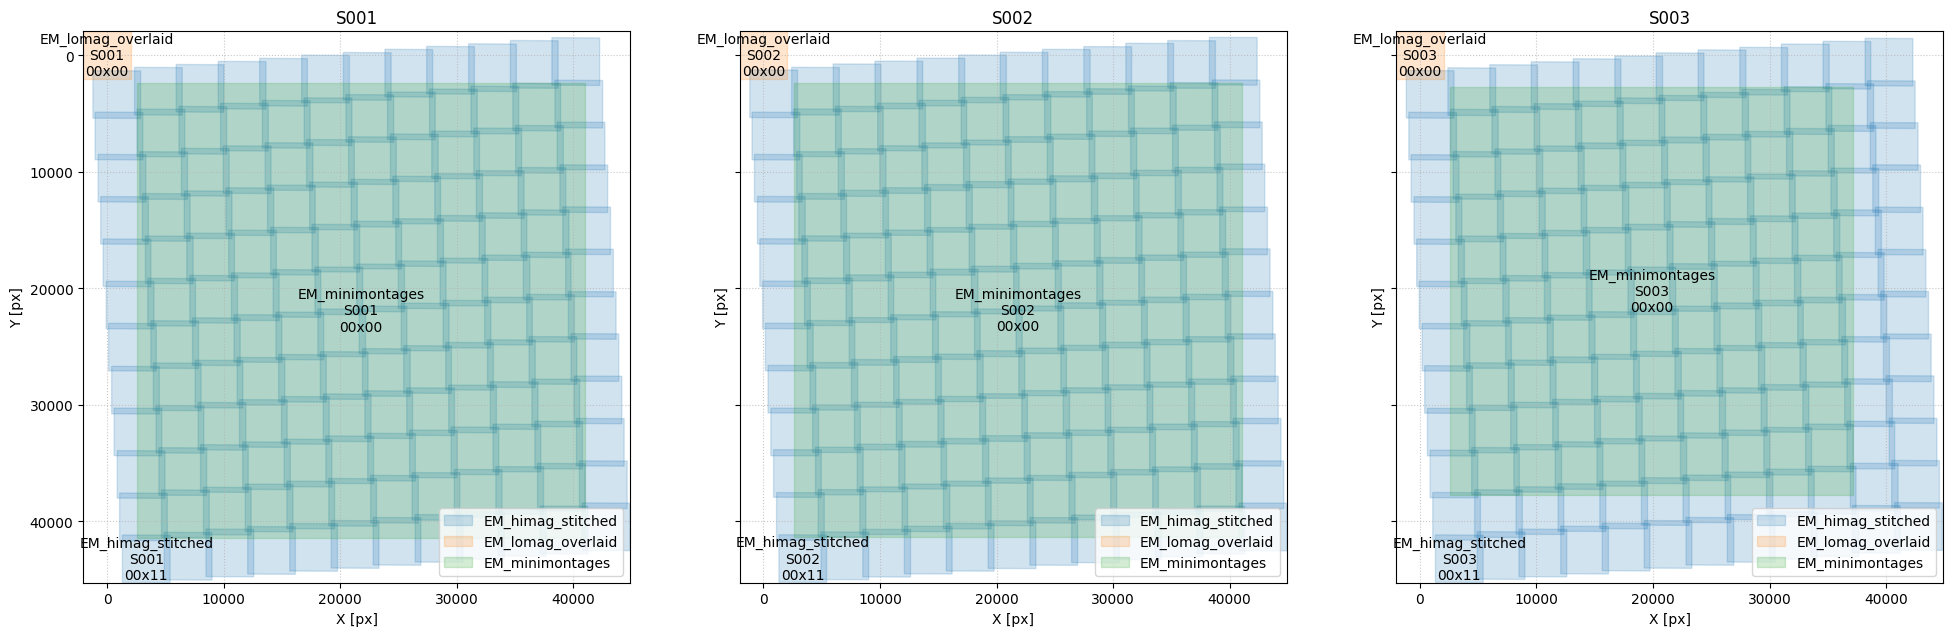

In [13]:
# Set stacks to plot
stacks_2_plot = list(stacks_2_correlate.values()) + [stack_mm]
# Plot tile map
icatapi.plot_tile_map(stacks=stacks_2_plot,
                      render=render, **render_connect_params)

#### Render images

## Generate correlative point matches
---

### Generate (low mag EM, mini-montage) tile pairs
`renderapi.client.tilePairClient` only generates tile pairs within an individual stack. Since low mag EM and mini-montage image tiles are stored in separate stacks, tile pairs are therefore generated manually.

In [14]:
# Initialize DataFrame of tile pairs
columns = ['p.stack', 'q.stack', 'z',
           'p.groupId', 'q.groupId',
           'p.id', 'q.id',
           'imageRow', 'imageCol']
df_pairs = pd.DataFrame(columns=columns)

# Iterate through mini-montage tiles
for i, q_tile in tqdm(df_minimontage.iterrows(),
                 total=len(df_minimontage)):

    # Find corresponding lo mag EM tile from overlapping tiles DataFrame
    p_tile = df_overlapping.loc[(df_overlapping['z'] == q_tile['z']) &\
                                (df_overlapping['imageRow'] == q_tile['imageRow']) &\
                                (df_overlapping['imageCol'] == q_tile['imageCol'])].iloc[0]

    # Populate DataFrame
    df_pairs.loc[i, 'p.stack'] = stacks_2_correlate['loMag']
    df_pairs.loc[i, 'q.stack'] = q_tile['stack']
    df_pairs.loc[i, 'z'] = q_tile['z']
    df_pairs.loc[i, 'p.groupId'] = p_tile['sectionId']
    df_pairs.loc[i, 'q.groupId'] = q_tile['sectionId']
    df_pairs.loc[i, 'p.id'] = p_tile['tileId']
    df_pairs.loc[i, 'q.id'] = q_tile['tileId']
    df_pairs.loc[i, 'imageRow'] = q_tile['imageRow']
    df_pairs.loc[i, 'imageCol'] = q_tile['imageCol']

# Preview
out = f"{len(df_pairs)} tile pairs"
print(out + '\n' + '.'*len(out))

df_pairs.head(6)

  0%|          | 0/3 [00:00<?, ?it/s]

3 tile pairs
............


p.stack         q.stack    z p.groupId q.groupId         p.id  \
0  EM_lomag_ov...  EM_minimont...  0.0      S001      S001  t0_z0_y0_x0   
1  EM_lomag_ov...  EM_minimont...  1.0      S002      S002  t0_z1_y0_x0   
2  EM_lomag_ov...  EM_minimont...  2.0      S003      S003  t0_z2_y0_x0   

             q.id imageRow imageCol  
0  mm-S001-000...        0        0  
1  mm-S002-000...        0        0  
2  mm-S003-000...        0        0

### Run `pointMatchClient` on (low mag EM, mini-montage) tile pairs
##### Set `SIFT` & `RANSAC` parameters

In [15]:
from functools import partial

from renderapi.client import (SiftPointMatchOptions,
                              MatchDerivationParameters,
                              FeatureExtractionParameters)

In [16]:
# `RANSAC` parameters
match_params = MatchDerivationParameters(matchIterations=5000,
                                         matchMaxEpsilon=25,        # maximal alignment error
                                         matchMaxNumInliers=None,
                                         matchMaxTrust=None,
                                         matchMinInlierRatio=0.01,  # minimal inlier ratio
                                         matchMinNumInliers=7,      # minimal number of inliers
                                         matchModelType='AFFINE',   # expected transformation
                                         matchRod=0.92)             # closest/next closest ratio
# `SIFT` parameters
feature_params = FeatureExtractionParameters(SIFTfdSize=8,          # feature descriptor size
                                             SIFTmaxScale=0.25,     # (width/height *) maximum image size
                                             SIFTminScale=0.02,     # (width/height *) minimum image size
                                             SIFTsteps=7)           # steps per scale octave
# Combined `SIFT` & `RANSAC` parameters
sift_options = SiftPointMatchOptions(**{**match_params.__dict__,
                                        **feature_params.__dict__})
list(sift_options.to_java_args())

['--SIFTfdSize',
 '8',
 '--SIFTmaxScale',
 '0.25',
 '--SIFTminScale',
 '0.02',
 '--SIFTsteps',
 '7',
 '--matchIterations',
 '5000',
 '--matchMaxEpsilon',
 '25',
 '--matchMinInlierRatio',
 '0.01',
 '--matchMinNumInliers',
 '7',
 '--matchModelType',
 'AFFINE',
 '--matchRod',
 '0.92']

In [17]:
##### `pointMatchClient` wrapper for parallelized processing

##### `pointMatchClient` wrapper for parallelized processing

In [18]:
def run_point_match_client(tile_pair_chunk, p_stack, q_stack, collection, sift_options, render):
    """Point match client wrapper supporting two different stacks for use in multiprocessing"""
    # print(p_stack)
    # print(q_stack)
    # print(collection)
    # print(tile_pair_chunk)
    renderapi.client.pointMatchClient(stack=p_stack,
                                      stack2=q_stack,
                                      collection=collection,
                                      tile_pairs=tile_pair_chunk,
                                      sift_options=sift_options,
                                      excludeAllTransforms=True,
                                      render=render,
                                      **render_connect_params)

#### \*\****COMPUTATIONALLY EXPENSIVE*** \**

##### Run `pointMatchClient` on `N_cores`

In [19]:
# # Set number of cores and batch size
# N_cores = 25
# batch_size = 12

# # Set match collection
# match_collection = f"{project}_minimontage_points"

# TODO: generalize this function to p stack and q stack
# # Generate point matches
# generate_point_matches(df_pairs,
#                        match_collections=match_collections,
#                        sift_options=sift_options,
#                        normalizeForMatching=True,
#                        N_cores=N_cores,
#                        batch_size=batch_size,
#                        render=render)

In [20]:
# Set number of cores and batch size
N_cores = 40
batch_size = 1

# Set match collection
match_collection = f"{project}_minimontage_points"

# Loop through sections of each montage stack
for z, tile_pairs in tqdm(df_pairs.groupby('z')):

    # Group tile pairs into batches
    grouping = np.arange(len(tile_pairs)) // batch_size
    for i, batch in tqdm(tile_pairs.groupby(grouping), leave=False):

        # Create batch of tile pairs
        tp_batch = [[tuple(tp)] for tp in batch[['p.id', 'q.id']].values.tolist()]

        # Set up `pointMatchClient` partial
        point_match_client_partial = partial(run_point_match_client,
                                             p_stack=df_pairs['p.stack'].iloc[0],
                                             q_stack=df_pairs['q.stack'].iloc[0],
                                             collection=match_collection,
                                             sift_options=sift_options,
                                             render=render)

        # Run `pointMatchClient` on `N_cores`
        with renderapi.client.WithPool(N_cores) as pool:
            pool.map(point_match_client_partial, tp_batch)
        # point_match_client_partial(tp_batch[0])

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

org.janelia.render.client.PointMatchClient

  Running: /home/catmaid/render/deploy/jdk1.8.0_131/bin/java -cp /home/catmaid/render/render-ws-java-client/target/render-ws-java-client-2.0.1-SNAPSHOT-standalone.jar -Xms2G -Xmx2G -Djava.awt.headless=true -XX:+UseSerialGC org.janelia.render.client.PointMatchClient --baseDataUrl http://localhost:8081/render-ws/v1 --owner skaracoban --collection 20240530_SK001_minimontage_points --SIFTfdSize 8 --SIFTmaxScale 0.25 --SIFTminScale 0.02 --SIFTsteps 7 --matchIterations 5000 --matchMaxEpsilon 25 --matchMinInlierRatio 0.01 --matchMinNumInliers 7 --matchModelType AFFINE --matchRod 0.92 http://localhost:8081/render-ws/v1/owner/skaracoban/project/20240530_SK001/stack/EM_lomag_overlaid/tile/t0_z0_y0_x0/render-parameters?filter=false&normalizeForMatching=true&renderWithoutMask=false&excludeAllTransforms=true http://localhost:8081/render-ws/v1/owner/skaracoban/project/20240530_SK001/stack/EM_minimontages/tile/mm-S001-00000x00000/render-parameters?filter=fa

  0%|          | 0/1 [00:00<?, ?it/s]

org.janelia.render.client.PointMatchClient

  Running: /home/catmaid/render/deploy/jdk1.8.0_131/bin/java -cp /home/catmaid/render/render-ws-java-client/target/render-ws-java-client-2.0.1-SNAPSHOT-standalone.jar -Xms2G -Xmx2G -Djava.awt.headless=true -XX:+UseSerialGC org.janelia.render.client.PointMatchClient --baseDataUrl http://localhost:8081/render-ws/v1 --owner skaracoban --collection 20240530_SK001_minimontage_points --SIFTfdSize 8 --SIFTmaxScale 0.25 --SIFTminScale 0.02 --SIFTsteps 7 --matchIterations 5000 --matchMaxEpsilon 25 --matchMinInlierRatio 0.01 --matchMinNumInliers 7 --matchModelType AFFINE --matchRod 0.92 http://localhost:8081/render-ws/v1/owner/skaracoban/project/20240530_SK001/stack/EM_lomag_overlaid/tile/t0_z1_y0_x0/render-parameters?filter=false&normalizeForMatching=true&renderWithoutMask=false&excludeAllTransforms=true http://localhost:8081/render-ws/v1/owner/skaracoban/project/20240530_SK001/stack/EM_minimontages/tile/mm-S002-00000x00000/render-parameters?filter=fa

  0%|          | 0/1 [00:00<?, ?it/s]

org.janelia.render.client.PointMatchClient

  Running: /home/catmaid/render/deploy/jdk1.8.0_131/bin/java -cp /home/catmaid/render/render-ws-java-client/target/render-ws-java-client-2.0.1-SNAPSHOT-standalone.jar -Xms2G -Xmx2G -Djava.awt.headless=true -XX:+UseSerialGC org.janelia.render.client.PointMatchClient --baseDataUrl http://localhost:8081/render-ws/v1 --owner skaracoban --collection 20240530_SK001_minimontage_points --SIFTfdSize 8 --SIFTmaxScale 0.25 --SIFTminScale 0.02 --SIFTsteps 7 --matchIterations 5000 --matchMaxEpsilon 25 --matchMinInlierRatio 0.01 --matchMinNumInliers 7 --matchModelType AFFINE --matchRod 0.92 http://localhost:8081/render-ws/v1/owner/skaracoban/project/20240530_SK001/stack/EM_lomag_overlaid/tile/t0_z2_y0_x0/render-parameters?filter=false&normalizeForMatching=true&renderWithoutMask=false&excludeAllTransforms=true http://localhost:8081/render-ws/v1/owner/skaracoban/project/20240530_SK001/stack/EM_minimontages/tile/mm-S003-00000x00000/render-parameters?filter=fa

### Analyze point matches

#### Collect point matches

In [21]:
# Initialize point matches DataFrame
matches_cols = ['p.stack', 'q.stack', 'z', 'p.groupId', 'q.groupId', 'p.id', 'q.id']
df_matches = df_pairs.loc[:, matches_cols].copy()
# Add columns for row, col, and number of point matches
df_matches['imageRow'] = np.nan
df_matches['imageCol'] = np.nan
df_matches['N'] = np.nan
df_matches['p.matches'] = None
df_matches['q.matches'] = None

# Iterate through tile pairs
for i, tp in tqdm(df_matches.iterrows(), total=len(df_matches)):

    # Get json point matches data for each tile pair
    matches_json = renderapi.pointmatch.get_matches_from_tile_to_tile(match_collection,
                                                                      pgroup=tp['p.groupId'],
                                                                      pid=tp['p.id'],
                                                                      qgroup=tp['q.groupId'],
                                                                      qid=tp['q.id'],
                                                                      render=render,
                                                                      **render_connect_params)
    # Check if point matches exist for tile pair
    if matches_json:
        # Normalize json to DataFrame
        df_json = pd.json_normalize(matches_json)
        # Count number of point matches
        df_matches.loc[i, 'N'] = np.array(df_json['matches.p'].iloc[0]).shape[1]
        # Add p, q matches
        df_matches.at[i, 'p.matches'] = df_json['matches.p'].iloc[0]
        df_matches.at[i, 'q.matches'] = df_json['matches.q'].iloc[0]
    # If no point matches exist
    else:
        df_matches.loc[i, 'N'] = 0
        df_matches.at[i, 'p.matches'] = []
        df_matches.at[i, 'q.matches'] = []

# Populate DataFrame with row, column and number of matches data
df_matches[['imageCol', 'imageRow']] = np.stack(df_matches['p.id'].apply(lambda x:\
                                           [int(i) for i in re.findall(r'\d+', x)[-2:]]))

# Preview
df_matches.head(5)

  0%|          | 0/3 [00:00<?, ?it/s]

p.stack         q.stack    z p.groupId q.groupId         p.id  \
0  EM_lomag_ov...  EM_minimont...  0.0      S001      S001  t0_z0_y0_x0   
1  EM_lomag_ov...  EM_minimont...  1.0      S002      S002  t0_z1_y0_x0   
2  EM_lomag_ov...  EM_minimont...  2.0      S003      S003  t0_z2_y0_x0   

             q.id  imageRow  imageCol      N       p.matches       q.matches  
0  mm-S001-000...         0         0  528.0  [[2505.0440...  [[2520.2344...  
1  mm-S002-000...         0         0  526.0  [[582.86492...  [[104.38917...  
2  mm-S003-000...         0         0  581.0  [[2328.4149...  [[2355.9144...

In [23]:
# import matplotlib.pyplot as plt

# fig, ax = plt.subplots(1, 3, figsize=(30, 10))

# for i, matches in enumerate([np.array(x) for x in df_matches["p.matches"].to_numpy()]):
#     matches_x, matches_y = matches
    
#     ax[i].scatter(matches_x, matches_y, c='r', s=5)
#     ax[i].set_title(df_matches['p.stack'].iloc[i] + f"section {df_matches['p.groupId'].iloc[i]}")
    
#     # get bounding box from renderapi
#     bbox = renderapi.tilespec.get_tile_spec(stack=df_matches['p.stack'].iloc[i],
#                                             tile=df_matches['p.id'].iloc[i],
#                                             render=render, **render_connect_params).bbox
    
#     # draw the bbox
#     ax[i].add_patch(plt.Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1], fill=None, edgecolor='b'))
    
    
# fig, ax = plt.subplots(1, 3, figsize=(30, 10))

# for i, matches in enumerate([np.array(x) for x in df_matches["q.matches"].to_numpy()]):
#     ax[i].scatter(matches[0], matches[1], c='r', s=5)
#     ax[i].set_title(df_matches['q.stack'].iloc[i] + f"section {df_matches['q.groupId'].iloc[i]}")
    
#     # get bounding box from renderapi
#     bbox = renderapi.tilespec.get_tile_spec(stack=df_matches['q.stack'].iloc[i],
#                                             tile=df_matches['q.id'].iloc[i],
#                                             render=render, **render_connect_params).bbox
    
#     # draw the bbox
#     ax[i].add_patch(plt.Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1], fill=None, edgecolor='b'))
    

#### Heatmap of point matches

In [24]:
# Data source
source = df_matches.drop(['p.matches', 'q.matches'], axis=1).copy()
source.loc[source['N'] == 0, 'N'] = np.nan

# Make heatmap
base = alt.Chart(source).encode(
    x='imageCol:O',
    y='imageRow:O'
)
heatmap = base.mark_rect().encode(
    color=alt.Color('N:Q'),
).properties(
    width=150,
    height=150
)
text = base.mark_text(baseline='middle').encode(
    text='N:Q',
)
# Facet heatmaps across sections and montage stacks
alt.layer(heatmap, text, data=source).facet(
    column=r'p\.groupId:N',
)

alt.FacetChart(...)

## Upload correlated stacks to `render-ws`
---

### Create DataFrame of correlated tile specifications
Basically means applying new set of affine transformations to overlaid stacks. But the exact transform and exact order of transforms here is super duper important. Also the fact that the poinmatch-based transform must be inverted. Also the fact that the initial big EM transform is tossed out.

The exact mapping from each big EM tile to each mini-montage is a combination of the
* Affine transform derived from `SIFT` point matches
* Scaling factor used to render the mini-montage.

In [25]:
from skimage.measure import ransac
from skimage.transform import AffineTransform as AffineSkimage

  0%|          | 0/3 [00:00<?, ?it/s]

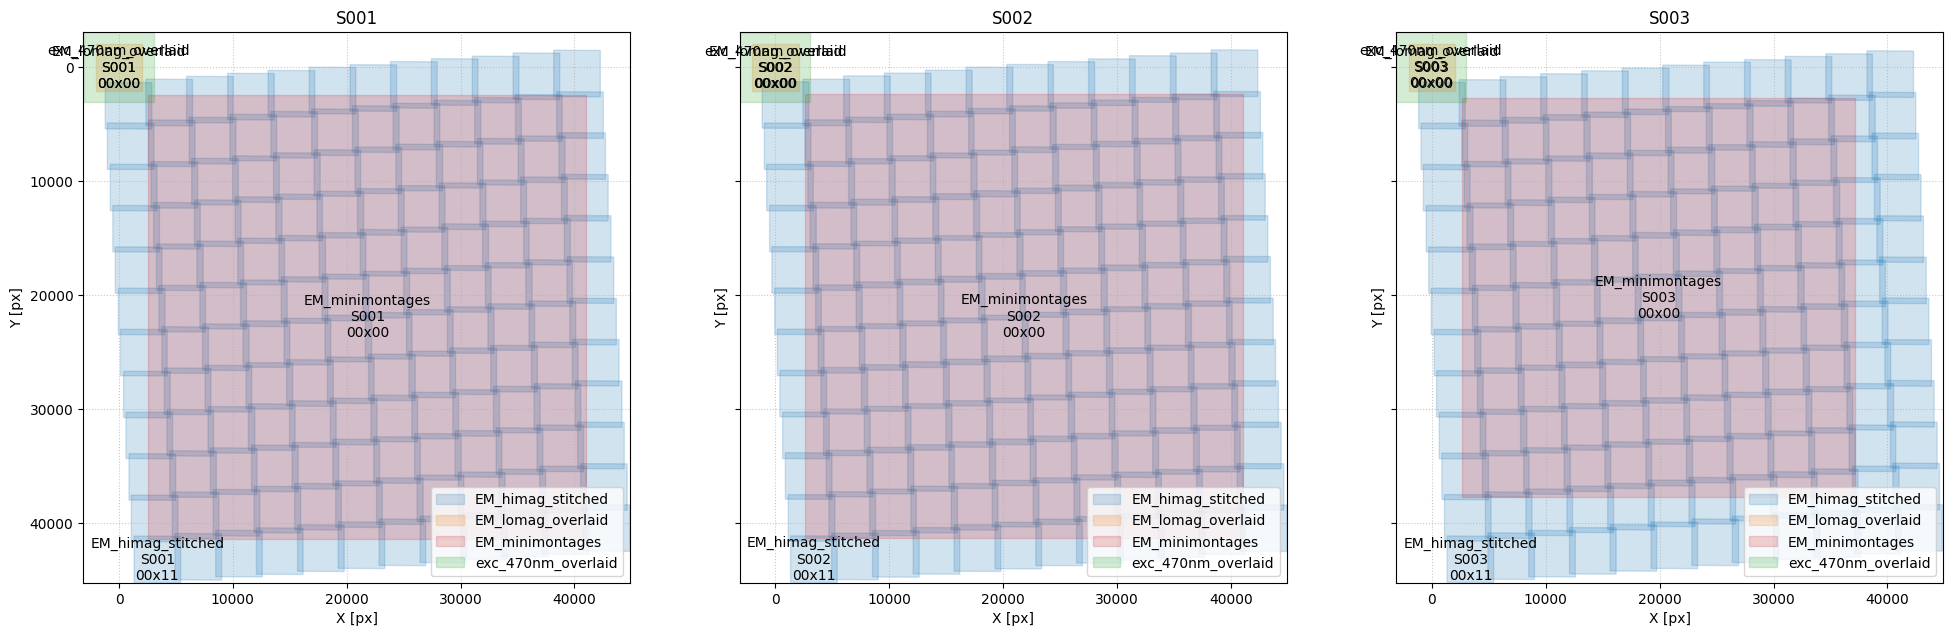

In [26]:
# Set stacks to plot
stacks_2_plot = list(stacks_2_correlate.values()) + \
                ['exc_470nm_overlaid'] + \
                [stack_mm]

# Plot tile map
icatapi.plot_tile_map(stacks=stacks_2_plot,
                      render=render, **render_connect_params)

In [68]:
# Initialize DataFrame of correlated tile specifications
stacks_overlaid = [stack for stack in stacks if 'overlaid' in stack]
df_correlative = icatapi.create_stacks_DataFrame(stacks=stacks_overlaid,
                                                 render=render, **render_connect_params)
df_correlative['N'] = np.nan

# Loop through FM and low mag EM overlay tiles
for i, tile in tqdm(df_correlative.iterrows(),
                    total=len(df_correlative)):

    # (Try to) get correlative (low mag EM, minimontage) point matches based on z, row, col
    try:
        matches = df_matches.loc[(df_matches['z'] == tile['z']) &\
                                 (df_matches['imageRow'] == tile['imageRow']) &\
                                 (df_matches['imageCol'] == tile['imageCol'])].iloc[0]
    except IndexError:  # simply means there is no minimontage for
        continue        # this CLEM tile (often the case)

    # Only compute transforms on tiles for which there are point matches with the minimontage
    if matches['N'] > 0:

#         # Carry over overlay transforms for FM stacks
#         if tile['stack'] in stacks_FM:
#             overlay_tforms = tile['tforms'][:2]

        # Compute point-match-based affine transform using `RANSAC`
        src = np.array(matches['p.matches']).T
        tgt = np.array(matches['q.matches']).T
        model, inliers = ransac((src, tgt),
                                model_class=AffineSkimage,
                                min_samples=7,          # not sure how optimal
                                residual_threshold=25)  # these parameters are
        # Convert model to `AffineRender`
        AR1 = AffineRender()
        AR1.M = model.params

        # Compute scaling transform based on downsampled minimontage image
        AR2 = df_minimontage.loc[(df_minimontage['z'] == tile['z']) &\
                                 (df_minimontage['imageRow'] == tile['imageRow']) &\
                                 (df_minimontage['imageCol'] == tile['imageCol']), 'tforms'].iloc[0][0]

        # Set transforms for correlative DataFrame
        if tile['stack'] in stacks_FM:
#             df_correlative.at[i, 'tforms'] = [AffineRender(B0=-1024, B1=-1024)] + [tile['tforms'][1]] + [AR1, AR2]
            # df_correlative.at[i, 'tforms'] = [AffineRender(B0=-1024, B1=-1024)] + [tile['tforms'][1]] + [AffineRender(B0=2048, B1=2048)] + [AR1, AR2]
            df_correlative.at[i, 'tforms'] =  [tile['tforms'][:2]] + [AffineRender(B0=2048, B1=2048)] + [AR1, AR2]
        else:  # low mag EM
#             df_correlative.at[i, 'tforms'] = [AffineRender(B0=-2048, B1=-2048)] + [AR1, AR2]
            df_correlative.at[i, 'tforms'] = [AR1, AR2]

        # Populate DataFrame
        df_correlative.loc[i, 'stack'] = tile['stack'].replace('_overlaid', '_correlated') 
        df_correlative.loc[i, 'N'] = matches['N']

# Remove tile from correlative DataFrame if no matches --> could not be correlated
df_correlative.dropna(inplace=True)  # (N = nan)
# Preview
df_correlative.groupby('stack')\
              .apply(lambda x: x.sample(1))

  0%|          | 0/6 [00:00<?, ?it/s]

/tmp/ipykernel_3230958/4000461086.py:59: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(1))


tileId    z   width  height   minint   maxint  \
stack                                                                   
EM_lomag_cor... 2  t0_z2_y0_x0  2.0  4096.0  4096.0  31383.0  35714.0   
exc_470nm_co... 3  t0_z0_y0_x0  0.0  2048.0  2048.0   3056.0   5092.0   

                     imagePyramid          tforms           stack sectionId  \
stack                                                                         
EM_lomag_cor... 2  [0, 1, 2, 3...  [M=[[1.1307...  EM_lomag_co...      S003   
exc_470nm_co... 3  [0, 1, 2, 3...  [[M=[[1.000...  exc_470nm_c...      S001   

                   imageRow  imageCol       stageX       stageY      N  
stack                                                                   
EM_lomag_cor... 2         0         0 -7313.204806  1328.582691  581.0  
exc_470nm_co... 3         0         0 -7157.975483  1741.818827  528.0

#### Preview correlative transforms

In [69]:
df_correlative.groupby('stack')\
              .apply(lambda x: x.head(1))['tforms'].values.tolist()

/tmp/ipykernel_3230958/2958645233.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.head(1))['tforms'].values.tolist()


[[M=[[1.256806,-0.001930],[-0.000815,1.259100]] B=[-620.103663,-682.538188],
  M=[[9.389893,0.000000],[0.000000,9.389893]] B=[2579.000000,2399.000000]],
 [[M=[[1.000000,0.000000],[0.000000,1.000000]] B=[-1024.000000,-1024.000000],
   M=[[2.978916,0.000000],[0.000000,2.991003]] B=[-14.929941,-17.656038]],
  M=[[1.000000,0.000000],[0.000000,1.000000]] B=[2048.000000,2048.000000],
  M=[[1.256806,-0.001930],[-0.000815,1.259100]] B=[-620.103663,-682.538188],
  M=[[9.389893,0.000000],[0.000000,9.389893]] B=[2579.000000,2399.000000]]]

### Create correlated stacks

In [70]:
for stack, df_stack in df_correlative.groupby('stack'):
    icatapi.upload_stack_DataFrame(df_stack,
                                   render=render, **render_connect_params)

Creating tile specifications for EM_lomag_correlated...
Importing tile specifications to EM_lomag_correlated...
org.janelia.render.client.ImportJsonClient

  Running: /home/catmaid/render/deploy/jdk1.8.0_131/bin/java -cp /home/catmaid/render/render-ws-java-client/target/render-ws-java-client-2.0.1-SNAPSHOT-standalone.jar -Xms2G -Xmx2G -Djava.awt.headless=true -XX:+UseSerialGC org.janelia.render.client.ImportJsonClient --baseDataUrl http://localhost:8081/render-ws/v1 --owner skaracoban --project 20240530_SK001 --stack EM_lomag_correlated /tmp/tmphd0m6w6x.json


10:54:45.276 [main] INFO  [org.janelia.render.client.ClientRunner] run: entry
10:54:45.435 [main] INFO  [org.janelia.render.client.ImportJsonClient] runClient: entry, parameters={
  "renderWeb" : {
    "baseDataUrl" : "http://localhost:8081/render-ws/v1",
    "owner" : "skaracoban",
    "project" : "20240530_SK001"
  },
  "tileSpecValidator" : { },
  "stack" : "EM_lomag_correlated",
  "tileFiles" : [
    "/tmp/tmphd0m6w6x.json"
 

#### Tile map

  0%|          | 0/3 [00:00<?, ?it/s]

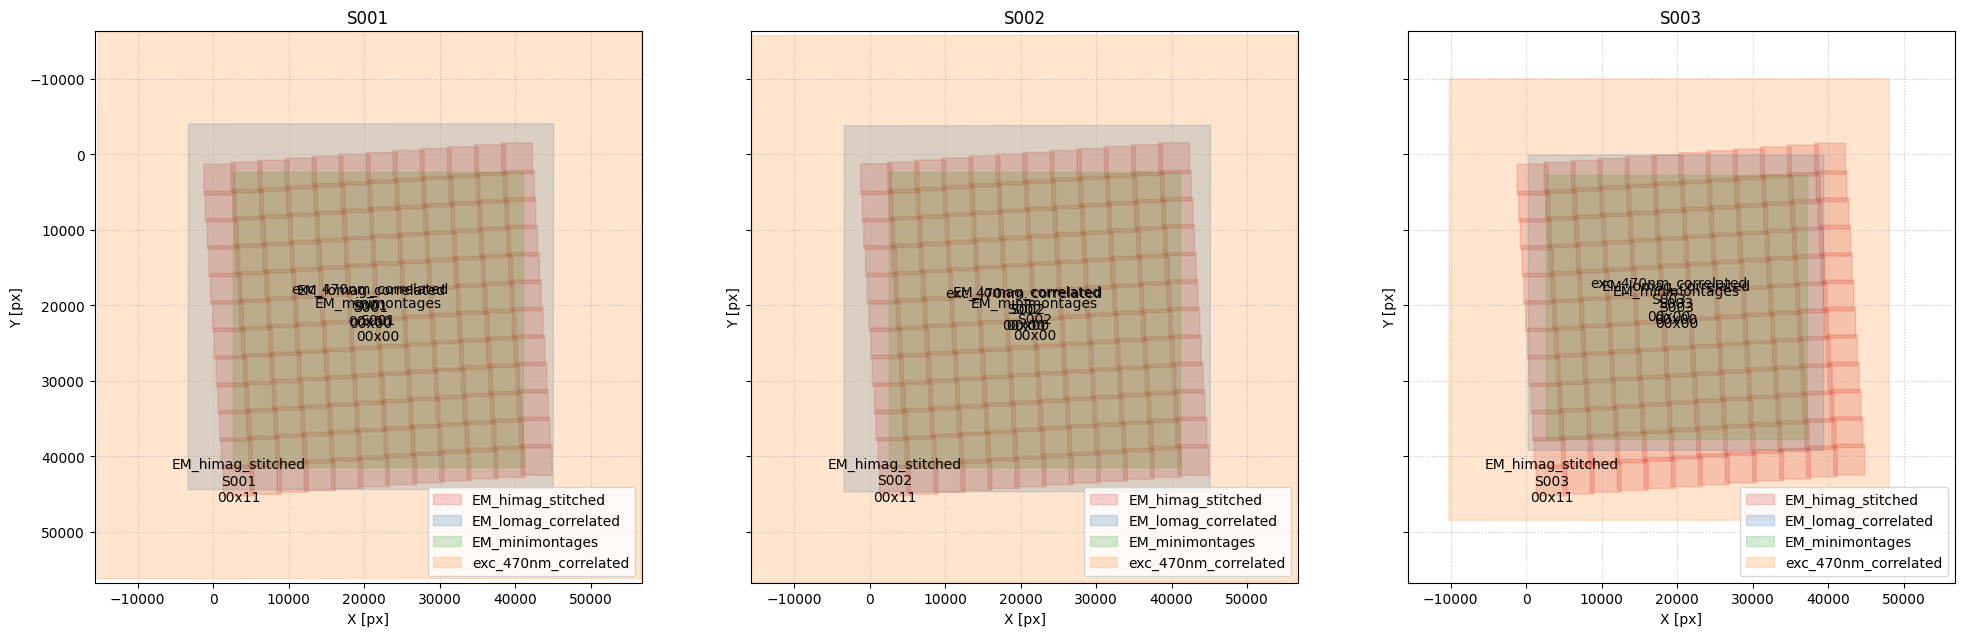

In [71]:
# Set stacks to plot
stacks_2_plot = df_correlative['stack'].unique().tolist() + \
                [stack_mm] + ["EM_himag_stitched"]

# Plot tile map
icatapi.plot_tile_map(stacks=stacks_2_plot,
                      render=render, **render_connect_params)

#### Render images

  0%|          | 0/9 [00:00<?, ?it/s]

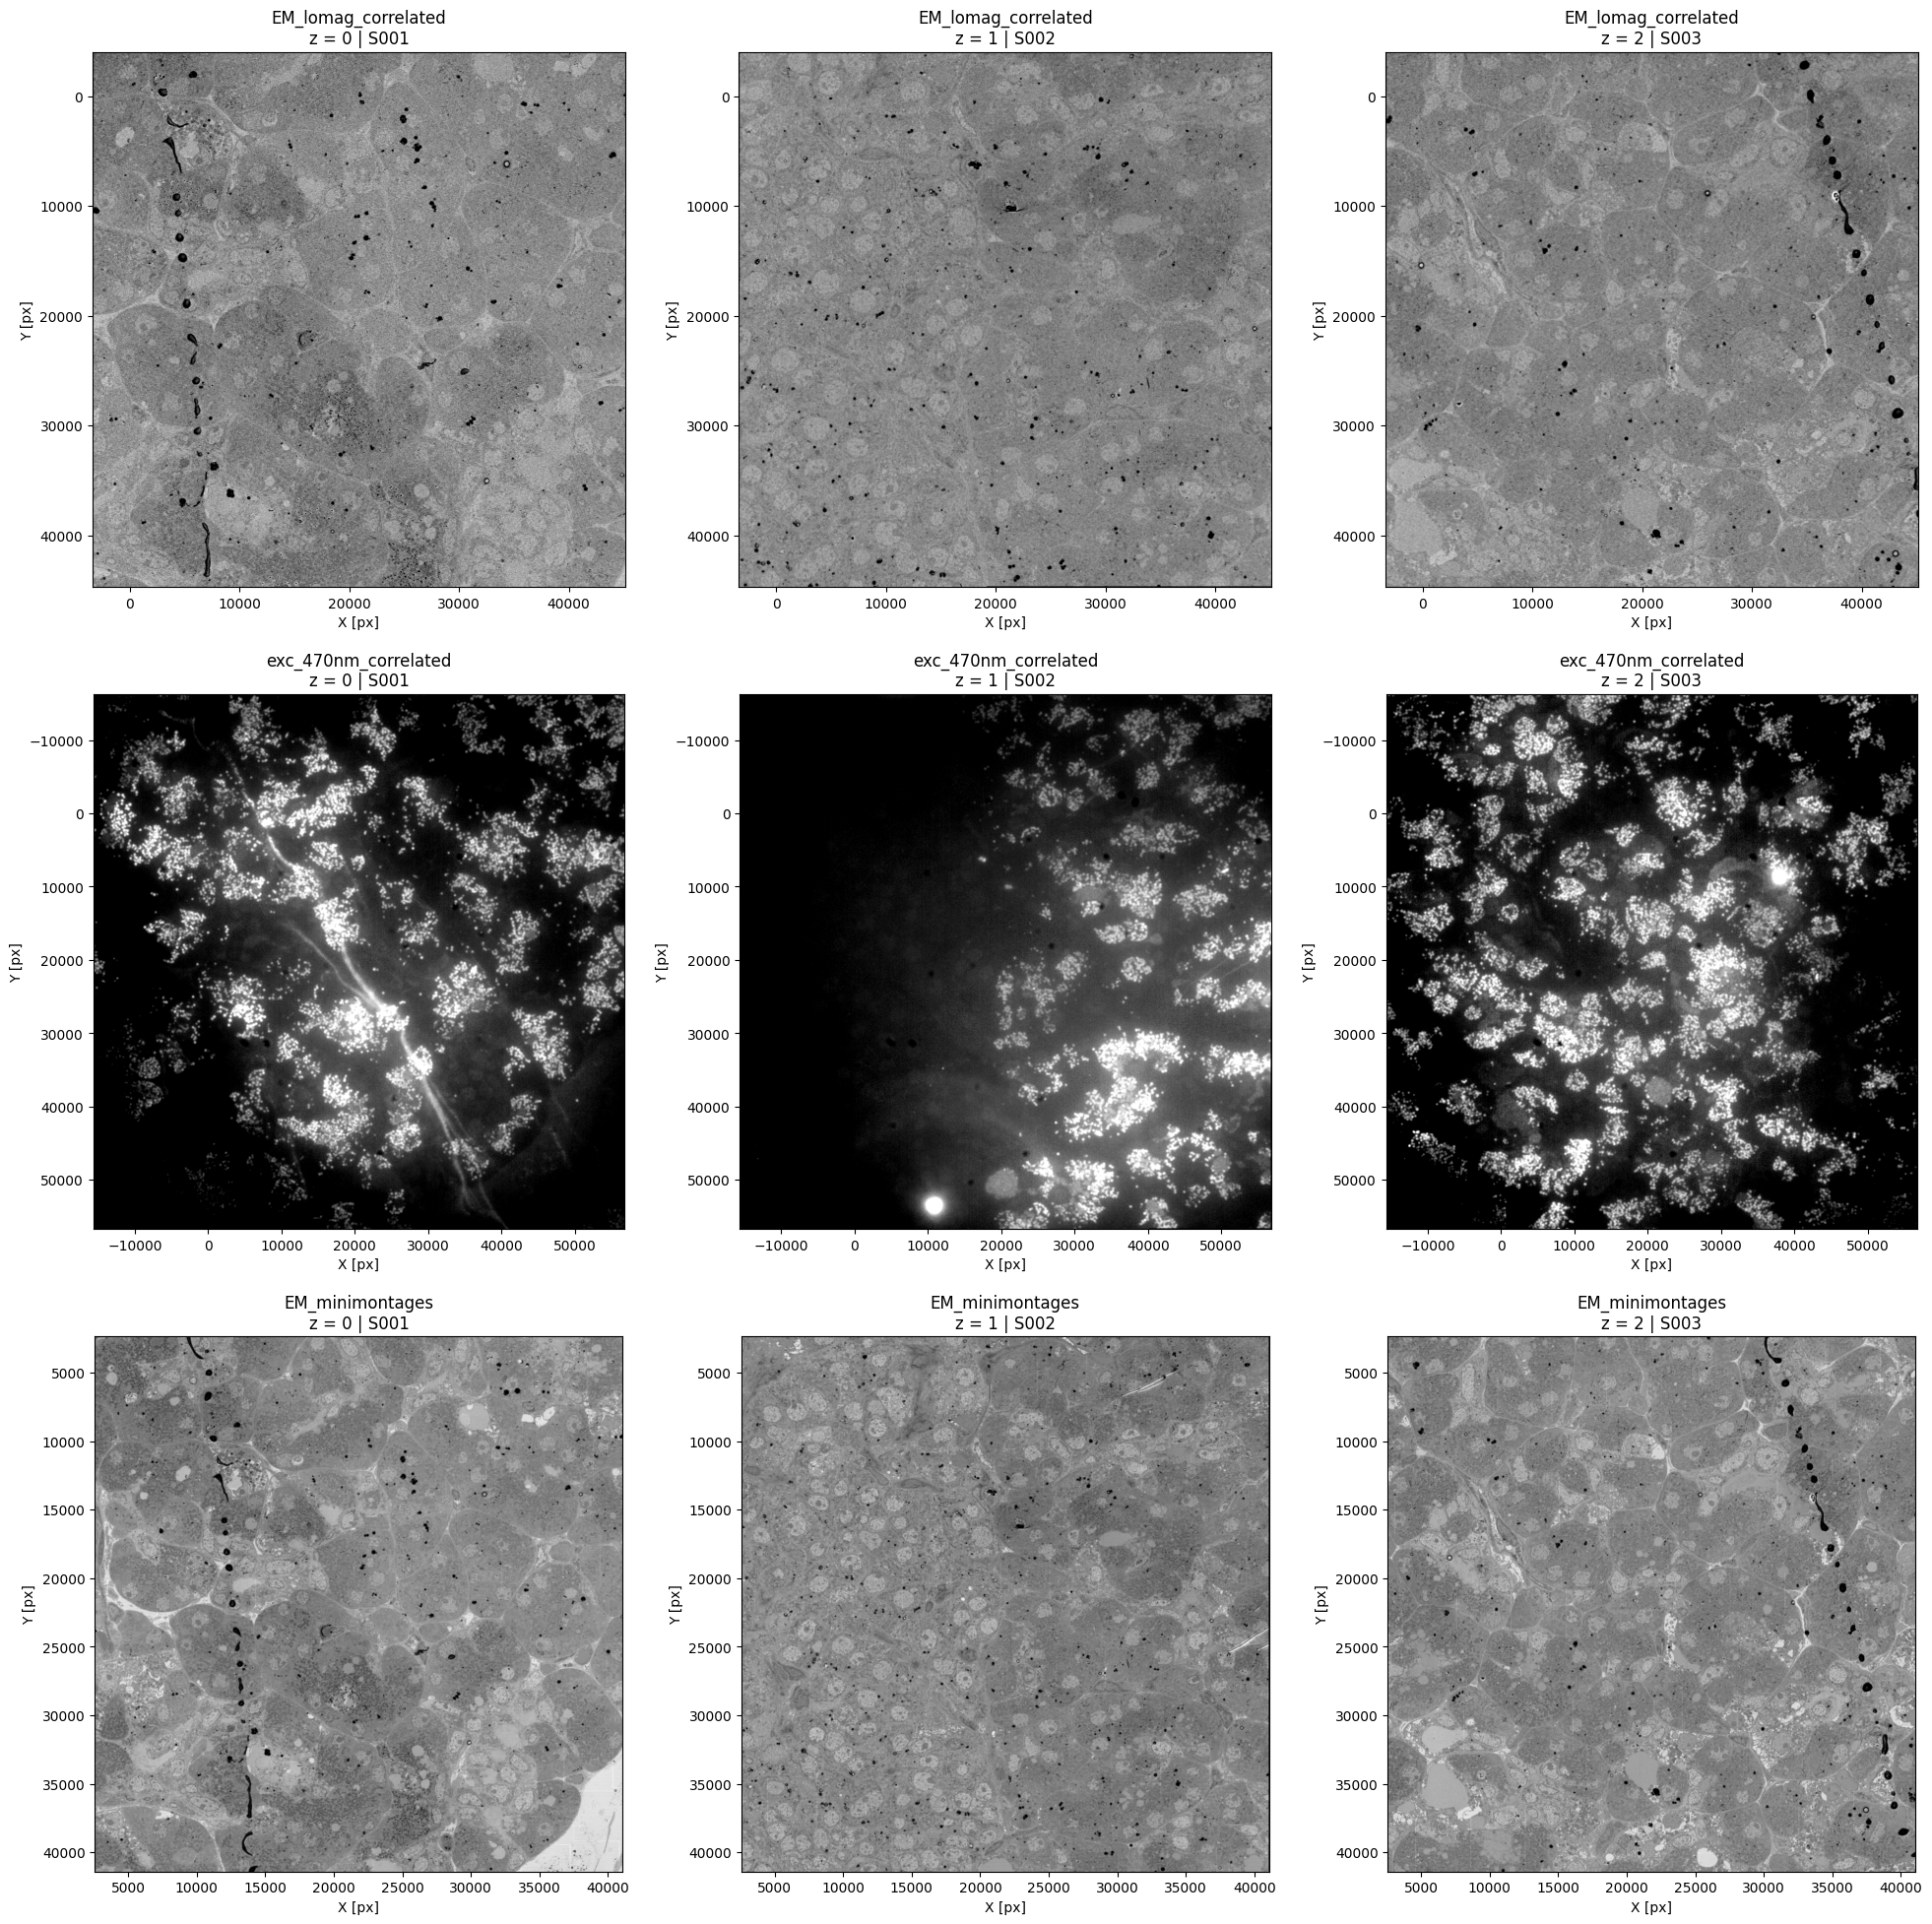

In [72]:
# Set stacks to plot
stacks_2_plot = df_correlative['stack'].unique().tolist() + \
                [stack_mm]

# Plot stacks
icatapi.plot_stacks(stacks=stacks_2_plot,
                    render=render, **render_connect_params)